In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium import webdriver
import re
from pandas.tseries.offsets import MonthEnd, MonthBegin
import pickle
%matplotlib inline

### Introduction/Summary

Short-term rental industry as of late as been a big focus for the sharing economy and local and state government. People who have been putting their dwelling (Hosts) on platforms such as AirBnB and HomeAway are able to make money by making use of empty room or perhaps their whole house or apartment on these platforms. Local and State governments are taking notice because these platforms are bypassing the local Hotel Occupancy Taxes that local Hotels have to pay.  No doubt the Hotel Lobbyists are putting pressure like how Taxi Lobbyists put pressure on officials with Uber. 

Property Management companies are also using these platforms because they can generate more profit than long-term leases, depending on what areas (i.e.Santa Monica, New York City). Sharing Economy tends to create a demand bubble, causing prices to increase. Due to this reason as well as bypassing Hotel Occupancy Taxes, many local and state officials are banning listings that are entire units. Austin, Santa Monica, San Francisco all have put severe restrictions into number of days that the unit can be listed, requiring permits, and/or banned entire unit rentals

New York signed a law stating that short-term rentals that consist of entire unit is now illegal. Is there a way around this law? If I have a 3 bedroom place that is on AirBnb, and let's say I am not living there, am I able to list it as a 2 Bedroom that is not private (I would say I am occupying one) and still generate profit than a long-term lease? I could also list a pull-out couch that can sleep two to keep the same occupancy, but then give them the room I was occupying?

This might work depending on location and rent in New York City. This analysis will focus on just that.

Using a dataset that is composed of studio, 1BR, 2BR, 3BR and 4BR units in NYC for the past 2 years, I will evaluate each of the features coefficients on price (date, seasonality, rent, neighborhood, square feet). If I am able to predict the price depending on number of bedrooms, I can compare it to the list of units available on Zillow.com to gauge if there are any units in NYC that would be a good fit to put on AirBnB or HomeAway. 

Using average price per night on HomeAway for each neighborhood and # of bedrooms, I can extrapolate expected revenues I get. Using hotel revpar (adr * occupancy), I can gauge what hotel average daily rate and occupancy are by month. ADR on the sharing economy platforms will be a percentage off of hotels (they will not be able to charge as high as hotels do), and using hotel data as trends for demand, I know when its high or low season.

In [2]:

resdata = pd.read_csv("/Users/amishdalal/DSI-NYC-2/projects/projects-capstone/Capstone_reservationdata.csv")
resdata = resdata[(resdata['Type']=="Reservation") & (resdata['Bedrooms'].notnull())]
resdata.drop(['Type'],axis=1, inplace = True)
resdata.reset_index(inplace = True,drop=True)

In [3]:
resdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2431 entries, 0 to 2430
Data columns (total 20 columns):
Property Code        2431 non-null object
Check-In             2431 non-null object
Check-Out            2431 non-null object
Confirmation Code    2431 non-null object
Nights               2431 non-null int64
Amount               2431 non-null object
Host Fee             2431 non-null int64
Cleaning Fee         2431 non-null float64
Cleaning Flag        2427 non-null float64
Cleaning_Rate        2431 non-null float64
Use                  2431 non-null float64
Rent                 2282 non-null float64
Market               2431 non-null object
Area                 2431 non-null object
Neighborhood         2350 non-null object
Address              2282 non-null object
Bedrooms             2431 non-null float64
Floor                2350 non-null float64
Seasonality          2426 non-null object
SqFoot               2282 non-null float64
dtypes: float64(8), int64(2), object(10)
memory

### Datetime Conversion

In [4]:
resdata['Check-In'] = pd.to_datetime(resdata['Check-In'])
resdata['Check-Out'] = pd.to_datetime(resdata['Check-Out'])


### Amount Column Conversion to float, Bedrooms to int

In [5]:
resdata['Amount'] = resdata['Amount'].apply(lambda x: str(x).replace('$',"")).apply(lambda x: str(x).replace(',',""))
resdata['Amount'] = resdata['Amount'].astype(float)

In [6]:
#converting bedrooms into integers
resdata['Bedrooms'] = resdata['Bedrooms'].astype(int)


In [7]:
print resdata.shape
resdata.isnull().sum()

(2431, 20)


Property Code          0
Check-In               0
Check-Out              0
Confirmation Code      0
Nights                 0
Amount                 0
Host Fee               0
Cleaning Fee           0
Cleaning Flag          4
Cleaning_Rate          0
Use                    0
Rent                 149
Market                 0
Area                   0
Neighborhood          81
Address              149
Bedrooms               0
Floor                 81
Seasonality            5
SqFoot               149
dtype: int64

### Calculating ADR

In [8]:
adr = ((resdata['Amount'] + resdata['Host Fee'] - resdata['Cleaning_Rate'])/resdata['Nights']).round(2)
adrloc = resdata.columns.get_loc('Cleaning_Rate') + 1
resdata.insert(adrloc,'ADR',adr)

In [9]:
#converting nights into int
resdata['Nights'] = resdata['Nights'].astype(int)

In [10]:
cols = ["Property Code","Check-In","Check-Out","Nights","Amount","ADR","Rent","Market","Area","Neighborhood",\
       "Bedrooms","Floor","Seasonality","SqFoot"]
data = resdata[resdata["ADR"]>0].loc[:,cols]
time_df = data.loc[:,["Property Code","Check-In","Check-Out","Nights","ADR","Bedrooms"]]
time_df['Check-In-Month'] = time_df['Check-In'].dt.month
time_df['Check-Out-Month'] = time_df['Check-Out'].apply(lambda x: (x-pd.offsets.Day(1))).dt.month
time_df['Check-In-Year'] = time_df['Check-In'].dt.year
time_df['Check-Out-Year'] = time_df['Check-Out'].dt.year

time_df['Diff_month'] = time_df['Check-Out-Month'] - time_df['Check-In-Month']
print time_df['Diff_month'].value_counts()
time_df['Diff_month'] = time_df['Diff_month'].apply(lambda x: 1 if x<0 else x)
time_df['Gross_Amount'] = time_df['Nights'] * time_df['ADR']


time_df['Month_Begin'] = time_df['Check-Out'].apply(lambda x: str(x.year)+"-"+str(x.month)+"-01")
time_df['Month_Begin'] = pd.to_datetime(time_df['Month_Begin'])

 0     2191
 1      216
-11      20
 3        1
Name: Diff_month, dtype: int64


In [11]:
time_df.head()

,Property Code,Check-In,Check-Out,Nights,ADR,Bedrooms,Check-In-Month,Check-Out-Month,Check-In-Year,Check-Out-Year,Diff_month,Gross_Amount,Month_Begin
0,Fourbed,2015-02-06,2015-02-08,2,475.0,4,2,2,2015,2015,0,950.0,2015-02-01
1,Fourbed,2015-02-13,2015-02-15,2,535.0,4,2,2,2015,2015,0,1070.0,2015-02-01
2,Fourbed,2015-02-16,2015-02-18,2,475.0,4,2,2,2015,2015,0,950.0,2015-02-01
3,Fourbed,2015-02-20,2015-02-22,2,550.0,4,2,2,2015,2015,0,1100.0,2015-02-01
4,Fourbed,2015-02-22,2015-02-25,3,475.0,4,2,2,2015,2015,0,1425.0,2015-02-01


In [13]:
def extract_nights(a,b):
    co_month_lst = []
    ci_nights_lst = []
    co_nights_lst = []
    month_begin_lst = []
    total_nights_lst = []
    i=0
    for x,y in zip(a,b):
        month_begin =  str(y.year)+"-"+str(y.month)+"-01"
        
        month_begin_ts = pd.to_datetime(month_begin)

        month_begin_lst.append(month_begin_ts)
        co_month = (y - pd.offsets.Day(1)).month
        co_month_lst.append(co_month)
        if x.month == y.month:
            ci_nights = (y-x).days
            ci_nights_lst.append(ci_nights)
            co_nights_lst.append(0)
            total_nights_lst.append(ci_nights)
        
        elif (y.month - x.month) == 1:
            #check in nights should be month_begin date minus check in date
            #ci_nights = (month_begin_ts - a).dt.days
            ci_nights = (month_begin_ts - x).days
            ci_nights_lst.append(ci_nights)
            #check out date should be check out date - month_begin date
            co_nights = (y-month_begin_ts).days
            co_nights_lst.append(co_nights)
            total_nights = ci_nights + co_nights
            total_nights_lst.append(total_nights)
        else:
            if (y.year - x.year)==1:
                ci_nights = (month_begin_ts - x).days
                ci_nights_lst.append(ci_nights)
                co_nights = (y-month_begin_ts).days
                co_nights_lst.append(co_nights)
                total_nights = ci_nights + co_nights
                total_nights_lst.append(total_nights)
            else:
                ci_nights_lst.append(0)
                co_nights_lst.append(0)
                total_nights_lst.append(0)
        i+=1
    nights_extracted = {"CI_nights":ci_nights_lst,"CO_nights":co_nights_lst,"total_nights":total_nights_lst}
    #nights_dic.append(nights_extracted)
        

    return nights_extracted

some_list = extract_nights(time_df['Check-In'],time_df['Check-Out'])
night_split = pd.DataFrame(some_list)
night_split.reset_index(inplace = True,drop=True)
time_df.reset_index(inplace = True,drop=True)
check = pd.concat([time_df,night_split],axis=1)
check['diff'] = check['Nights'] - check['total_nights']
print check['diff'].value_counts()

0     2427
89       1
Name: diff, dtype: int64


In [74]:
data = pd.concat([time_df,night_split],axis=1)
occupancy = data.groupby(['Property Code',"Check-In-Month","Check-Out-Month"])\
        ["CI_nights","CO_nights"].sum()
occupancy.reset_index(inplace = True)
occupancy

,Property Code,Check-In-Month,Check-Out-Month,CI_nights,CO_nights
0,DD-1BR,1,1,12,0
1,DD-1BR,1,2,9,9
2,DD-1BR,2,2,29,0
3,DD-1BR,2,3,2,14
4,DD-1BR,3,3,20,0
5,DD-1BR,3,4,16,2
6,DD-1BR,4,4,44,0
7,DD-1BR,4,5,5,6
8,DD-1BR,5,5,40,0
9,DD-1BR,5,6,7,13


In [72]:
data = pd.concat([time_df,night_split],axis=1)
occupancy = data.groupby(['Property Code',"Check-In","Check-Out","Check-In-Month","Check-Out-Month"])\
        ["CI_nights","CO_nights"].sum()
occupancy.reset_index(inplace = True)
occupancy

,Property Code,Check-In,Check-Out,Check-In-Month,Check-Out-Month,CI_nights,CO_nights
0,DD-1BR,2012-12-18,2013-01-02,12,1,14,1
1,DD-1BR,2013-02-14,2013-02-17,2,2,3,0
2,DD-1BR,2013-02-27,2013-03-15,2,3,2,14
3,DD-1BR,2013-03-16,2013-04-03,3,4,16,2
4,DD-1BR,2013-04-04,2013-04-18,4,4,14,0
5,DD-1BR,2013-04-20,2013-04-27,4,4,7,0
6,DD-1BR,2013-04-27,2013-05-04,4,5,4,3
7,DD-1BR,2013-05-04,2013-05-10,5,5,6,0
8,DD-1BR,2013-05-10,2013-05-25,5,5,15,0
9,DD-1BR,2013-05-28,2013-06-13,5,6,4,12


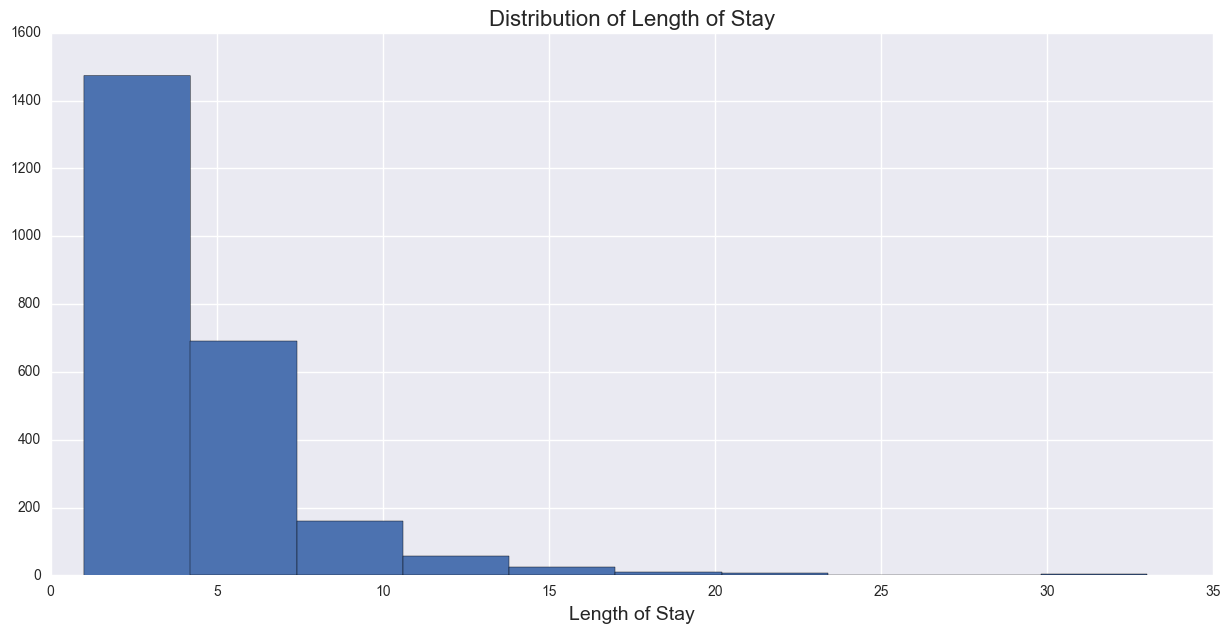

In [46]:
time_df[time_df['Nights']<89]['Nights'].hist(figsize=(15,7))
plt.title("Distribution of Length of Stay",fontsize=16)
plt.xlabel("Length of Stay",fontsize=14);

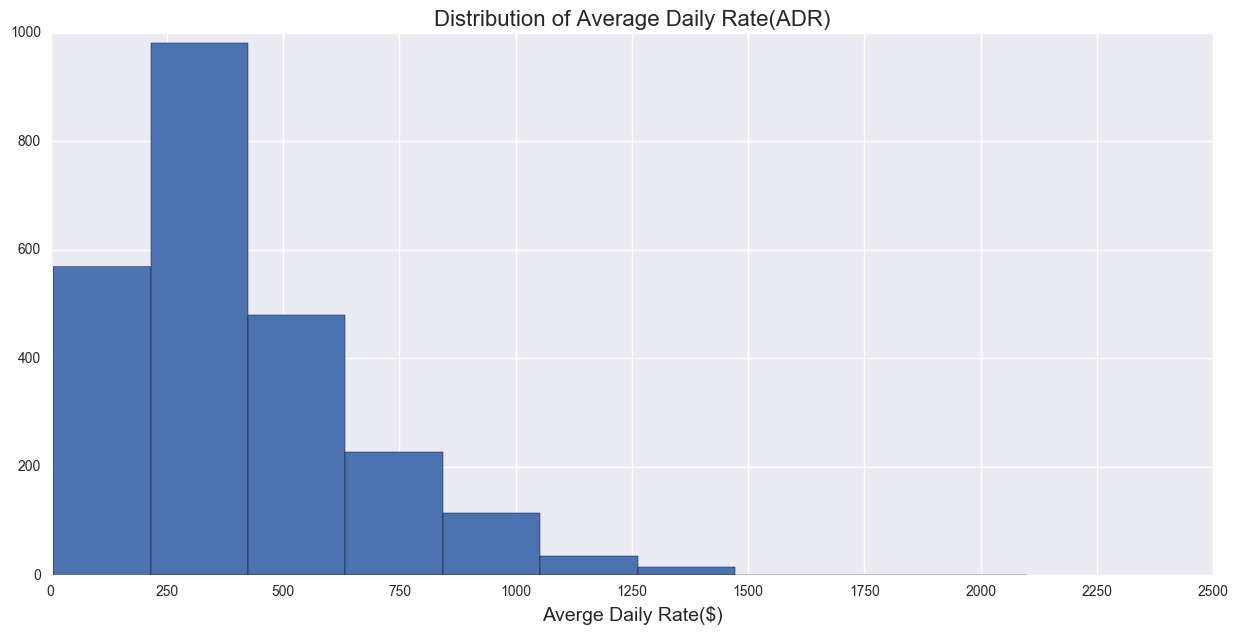

In [54]:
time_df['ADR'].hist(figsize=(15,7))
plt.title("Distribution of Average Daily Rate(ADR)",fontsize=16)
plt.xlabel("Averge Daily Rate($)",fontsize=14)
plt.xticks([0,250,500,750,1000,1250,1500,1750,2000,2250,2500]);

### Scraping StreetEasy to find Price per Sq Foot for Neighborhoods in NYC

http://streeteasy.com/blog/priciest-nyc-neighborhoods-by-square-foot/

manually add neighborhoods not in the table

In [14]:
URL = "http://streeteasy.com/blog/priciest-nyc-neighborhoods-by-square-foot/"
se = requests.get(URL)
soup_se = BeautifulSoup(se.text,"lxml")
print soup_se.prettify()

<!DOCTYPE html>
<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#">
 <head>
  <title>
   Priciest NYC Neighborhood by Square Foot? It's Central Park South | StreetEasy
  </title>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="http://streeteasy.com/blog/wp-content/themes/streeteasy-blog/favicon_2.ico" rel="shortcut icon"/>
  <link href="//fonts.googleapis.com/css?family=Source+Sans+Pro:400,200italic,200,300,300italic,900italic,900,700italic,700,600italic,600,400italic" rel="stylesheet" type="text/css"/>
  <link href="http://streeteasy.com/blog/feed/" rel="alternate" title="StreetEasy Blog Feed" type="application/rss+xml"/>
  <!-- Google Tag Manager for WordPress by DuracellTomi - http://duracelltomi.com -->
  <script data-cfasync="false" type="text/javascript">
   var gtm4wp_datalayer_name = "dataLayer";
	var dataLayer = dataLayer || []

	var gtm4wp_scro

In [15]:
street_easy = []
for x in  soup_se.findAll('td'):
    street_easy.append(x.text)

nhoods = street_easy[1::2]

ppsqft = street_easy[2::2]

nhood_price_ft = pd.DataFrame([nhoods,ppsqft],index=['Neighborhood','Price_Sqfoot']).T
nhood_price_ft['Price_Sqfoot'] = nhood_price_ft['Price_Sqfoot'].apply(lambda x: x.replace('$','')).\
             apply(lambda x: x.replace(',','')).astype(float)

add_nhoods = [["East Village",1331.63],["Lower East Side",999],["Greenpoint",988.07],["Brooklyn Heights",1069.11],["Park Slope",1018.04],\
["Kips Bay",911.14],["Murray Hill",1126.21],["Midtown South",1291.59],["Midtown East",1115.38],\
["Turtle Bay",1242.07],["Upper East Side",1262.9],["Bushwick",698.43],["Williamsburg",1165.04],["Sutton Place",957.5],\
["Prospect Heights",963.71],["Crown Heights",789.6],["Bedford-Stuyvesant",642.86],["Carroll Gardens",1164.58],["Boerum Hill",1214.73]]
add_nhood_df = pd.DataFrame(add_nhoods,columns=['Neighborhood','Price_Sqfoot'])
add_nhood_df["Price_Sqfoot"] = add_nhood_df["Price_Sqfoot"].astype(float)
nhood_price_ft = nhood_price_ft.append(add_nhood_df)
nhood_price_ft.sort_values("Price_Sqfoot",ascending=False,inplace = True)
nhood_price_ft.reset_index(inplace = True,drop = True)
nhood_price_ft.head()

,Neighborhood,Price_Sqfoot
0,Central Park South,2521.05
1,Tribeca,2018.53
2,Nolita,2005.06
3,SoHo,1991.89
4,Flatiron,1928.92


### Scraping Zillow

In [16]:
#z_URL = "http://www.zillow.com/brooklyn-new-york-ny-11249/rentals/"
z_URL = "http://www.zillow.com/williamsburg-brooklyn-new-york-ny/rentals/"
z = requests.get(z_URL)
soup_z = BeautifulSoup(z.text,"lxml")
print soup_z.prettify()

<!DOCTYPE html>
<html class="wf-loading no-js zsg-theme-modernized null" itemscope="" itemtype="http://schema.org/Organization" lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#" xmlns:product="http://ogp.me/product#">
 <head>
  <meta content="on" http-equiv="x-dns-prefetch-control"/>
  <link href="//www.zillowstatic.com" rel="preconnect"/>
  <link href="//fonts.googleapis.com" rel="preconnect"/>
  <link href="//photos.zillowstatic.com" rel="preconnect"/>
  <link href="//fonts.gstatic.com" rel="preconnect"/>
  <link href="//ajax.googleapis.com" rel="preconnect"/>
  <link href="//google-analytics.com" rel="preconnect"/>
  <link href="//b.scorecardresearch.com" rel="preconnect"/>
  <link href="//stats.g.doubleclick.net" rel="preconnect"/>
  <link href="//googletagmanager.com" rel="preconnect"/>
  <link href="//googletagservices.com" rel="preconnect"/>
  <meta charset="utf-8"/>
  <title>
   Rental Listings in Williamsbu

In [17]:
scraping_links = pd.read_csv("../scraping_links.csv")
for url in scraping_links["Zillow_Links"].drop_duplicates():
    print url

http://www.zillow.com/Central-Park-S-Central-Park-New-York-NY-10019/rentals/
http://www.zillow.com/Tribeca-New-York-NY/rentals/
http://www.zillow.com/SoHo-New-York-NY/rentals/
http://www.zillow.com/Flatiron-District-New-York-NY/rentals/
http://www.zillow.com/West-Village-New-York-NY/rentals/
http://www.zillow.com/Chelsea-New-York-NY/rentals/
http://www.zillow.com/Midtown-New-York-NY/rentals/
http://www.zillow.com/Greenwich-Village-New-York-NY/rentals/
http://www.zillow.com/Upper-West-Side-New-York-NY/rentals/
http://www.zillow.com/Upper-East-Side-New-York-NY/rentals/
http://www.zillow.com/Battery-Park-New-York-NY/rentals/
http://www.zillow.com/DUMBO-New-York-NY/rentals/
http://www.zillow.com/Financial-District-New-York-NY/rentals/
http://www.zillow.com/Gramercy-New-York-NY/rentals/
http://www.zillow.com/East-Village-New-York-NY/rentals/
http://www.zillow.com/Turtle-Bay-New-York-NY/rentals/
http://www.zillow.com/Boerum-Hill-New-York-NY/rentals/
http://www.zillow.com/Williamsburg-New-Yor

In [19]:
import time

#skip = []
#out = []
zillow_urls = scraping_links["Zillow_Links"].drop_duplicates()
links = zillow_urls
links.pop(18)  #financial district results in issues, need to pull separately
def get_zillow(links):
    all_listings = []
    out = []
    listings = {}
    total = 0
#     for url in series.drop_duplicates():
#         all_url.append(url)
    #print links
    for page in links:
#        try:
#        print link
        z = requests.get(page)
        soup_z = BeautifulSoup(z.text,"lxml")
#        zillow = soup_z.findAll('article')
#        print soup_z.find("title").get_text()
        total = soup_z.find("title").get_text().split("-")[1].split("|")[0].split(" ")[1].replace(",","")
        total = int(total)
        total_pages = int(round(total/float(26)))
        print page,total,total_pages
        i=0
        for y in range(1,(total_pages)+1):
            page_np = page+str(y)+"_p/"
            np = requests.get(page_np)
            print page_np
            soup_np = BeautifulSoup(np.text,"lxml")
            zillow = soup_z.findAll('article')
            for listing in zillow:
                address =  listing.find('span',{"class":"zsg-photo-card-address"}).text   #address
                link =  listing.a["href"]  #link
                for x in listing.find('div',{"class":"minibubble template hide"}):
                    sqft =  str(x).split("sqft")[-1].split(',')[0].replace(":","").replace("\"","") #sqft
                    beds =  int(str(x).split("\"bed\":")[1].split(',')[0]) #beds
                    if "priceRange" in str(x):
                        price =  str(x).split("\"priceRange\":")[1].split("\\\/mo")[0].replace("+","\"").replace("$","").replace(",","")
                    else:
                        if "title" in str(x):
                            price =  int(str(x).split("\"title\":")[1].split("\\\/mo")[0].replace("$","").replace(",","").replace("\"",""))
            #print i, address, link, sqft, beds, price
                listings = {"address":address,"link":link,"sqft":sqft,"beds":beds,"price":price,"listing_no":i,\
                           "main_url":page,"url":page_np}
                all_listings.append(listings)
                i+=1
        time.sleep(60)
        out = out + all_listings
    return out

In [ ]:
zillow_listings = get_zillow(links)

with open('zillow_main.pkl', 'w') as picklefile:
    pickle.dump(zillow_listings, picklefile)

In [22]:
with open('zillow_main.pkl', 'r') as picklefile:
    zillow_listings = pickle.load(picklefile)
    
    
zillow_main = pd.DataFrame(zillow_listings)


In [23]:
#grabbing Financial District  because it gave an error while using get_zillow function
url="http://www.zillow.com/Financial-District-New-York-NY/rentals/"
z = requests.get(url)
soup_z = BeautifulSoup(z.text,"lxml")
soup_z.find("title").get_text()
fidi_urls = []
for x in range(1,5):
    fidi_urls.append(url+str(x)+"_p/")
fidi_urls
i=0
zillow = soup_z.findAll('article')
total = soup_z.find("title").get_text().split("-")[1].split("|")[0].split(" ")[1].replace(",","")
total = int(total)
#print total
fidi_listings = []
for fidi_url in fidi_urls:
    for listing in zillow:
        address =  listing.find('span',{"class":"zsg-photo-card-address"}).text   #address
        link =  listing.a["href"]  #link
        for x in listing.find('div',{"class":"minibubble template hide"}):
            sqft =  str(x).split("sqft")[-1].split(',')[0].replace(":","").replace("\"","") #sqft
            beds =  (str(x).split("\"bed\":")[1].split(',')[0]) #beds
            if "priceRange" in str(x):
                price =  str(x).split("\"priceRange\":")[1].split("\\\/mo")[0].replace("+","\"").replace("$","").replace(",","")
            else:
                if "title" in str(x):
                    price =  int(str(x).split("\"title\":")[1].split("\\\/mo")[0].replace("$","").replace(",","").replace("\"",""))
    #print i, address, link, sqft, beds, price
        fidi_lists = {"address":address,"link":link,"sqft":sqft,"beds":beds,"price":price,"listing_no":i,\
                           "main_url":url,"url":fidi_url}
        fidi_listings.append(fidi_lists)
        #print listings
        i+=1
    #print fidi_url
fidi_df = pd.DataFrame(fidi_listings)
zillow = zillow_main.append(fidi_df)
zillow.reset_index(inplace = True, drop=True)
zillow.to_csv("Zillow_df_scraped.csv")

In [27]:
zillow = zillow.drop_duplicates()
zillow.reset_index(inplace = True,drop=True)
zillow

,address,beds,link,listing_no,main_url,price,sqft,url
0,"311 W 50th St, New York, NY",0,"/b/311-W-50th-St-New-York-NY/40.762887,-73.986...",0,http://www.zillow.com/Central-Park-S-Central-P...,"""2995""",null,http://www.zillow.com/Central-Park-S-Central-P...
1,"260 W 54th St, New York, NY",1,/b/marc-new-york-ny-3Hkm/,1,http://www.zillow.com/Central-Park-S-Central-P...,"""3338""",705,http://www.zillow.com/Central-Park-S-Central-P...
2,"796 9th Ave, New York, NY",1,"/b/796-9th-Ave-New-York-NY/40.765068,-73.98738...",2,http://www.zillow.com/Central-Park-S-Central-P...,"""2195""",null,http://www.zillow.com/Central-Park-S-Central-P...
3,"322 W 57th St, New York, NY",0,"/b/322-W-57th-St-New-York-NY/40.766986,-73.983...",3,http://www.zillow.com/Central-Park-S-Central-P...,"""3450""",null,http://www.zillow.com/Central-Park-S-Central-P...
4,"355 W 51st St APT 52, New York, NY",2,/homedetails/355-W-51st-St-APT-52-New-York-NY-...,4,http://www.zillow.com/Central-Park-S-Central-P...,2950,null,http://www.zillow.com/Central-Park-S-Central-P...
5,"400 W 56th St APT 2A, New York, NY",2,/homedetails/400-W-56th-St-APT-2A-New-York-NY-...,5,http://www.zillow.com/Central-Park-S-Central-P...,3995,null,http://www.zillow.com/Central-Park-S-Central-P...
6,"305 W 50th St, New York, NY",0,/b/longacre-house-apartments-new-york-ny-5XjKmM/,6,http://www.zillow.com/Central-Park-S-Central-P...,"""2860""",469,http://www.zillow.com/Central-Park-S-Central-P...
7,"342 W 56th St APT 1B, New York, NY",0,/homedetails/342-W-56th-St-APT-1B-New-York-NY-...,7,http://www.zillow.com/Central-Park-S-Central-P...,2200,350,http://www.zillow.com/Central-Park-S-Central-P...
8,"106 Central Park S, New York, NY",0,"/b/106-Central-Park-S-New-York-NY/40.76535,-73...",8,http://www.zillow.com/Central-Park-S-Central-P...,"""2550""",360,http://www.zillow.com/Central-Park-S-Central-P...
9,"150 W 56th St APT 2812, New York, NY",1,/homedetails/150-W-56th-St-APT-2812-New-York-N...,9,http://www.zillow.com/Central-Park-S-Central-P...,4600,950,http://www.zillow.com/Central-Park-S-Central-P...


In [446]:
# #link
# i=0
# for x in soup_z.find('ul',{"class":"photo-cards"}):
#     print i, x.a["href"]
#     i+=1

# #address
# i=0
# for x in  soup_z.findAll('span',{"class":"zsg-photo-card-address"}):
#     print i,x.text
#     i+=1

# #sqft
# i=0
# for x in  soup_z.findAll('div',{"class":"minibubble template hide"}):
#     print i,str(x).split("sqft")[-1].split(',')[0]
#     i+=1

# #beds
# i=0
# for x in  soup_z.findAll('div',{"class":"minibubble template hide"}):
#     #print i,x
#     print i,str(x).split("\"bed\":")[1].split(',')[0]
#     i+=1

# #price
# i=0
# for x in  soup_z.findAll('div',{"class":"minibubble template hide"}):
#     #print i,x
#     if "priceRange" in str(x):
#         print i,str(x).split("\"priceRange\":")[1].split("\\\/mo")[0].replace("+","\"")
#     else:
#         if "title" in str(x):
#             print i,str(x).split("\"title\":")[1].split("\\\/mo")[0]
#         #print i,0
#     i+=1



### Scraping Hotels.com

Need Revpar by month for NYC, instead (PwC pdf)

### Scraping for WalkScore

In [28]:
ny_neighborhoods = []
ws_url = "https://www.walkscore.com/NY/New_York/West_Village"
ws = requests.get(ws_url)
soup_ws = BeautifulSoup(ws.text,"lxml")
print soup_ws.prettify()


<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# walk-score: http://ogp.me/ns/fb/walk-score#">
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1.0 user-scalable=yes" name="viewport"/>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="en" http-equiv="content-language"/>
  <meta content="app-id=536017866" name="ws-apple-itunes-app"/>
  <meta content="app-id=com.walkscore.neighborhoods" name="google-play-app"/>
  <meta content="4B461FBFB34199E256F083A963A8CE34" name="msvalidate.01"/>
  <link href="https://pp.walk.sc/_/s/_g/4c9c1d4471abe1b7d176ebf1c0700f57.css" rel="stylesheet"/>
  <style type="text/css">
  </style>
  <title>
   West Village New York Apartments for Rent and Rentals - Walk Score
  </title>
  <meta content="Find West Village New York apartments for rent. View ph

In [29]:
walk_score_link = pd.read_csv("../scraping_links.csv")
all_urls = walk_score_link["Walk_Score_Link"].drop_duplicates()
walk_score = []
transit_score = []
bike_score = []
residents = []
def extract_walkscore(urls):
    for url in urls:
        ws = requests.get(url)
        soup_ws = BeautifulSoup(ws.text,"lxml")
        neighborhood = url.split("https://www.walkscore.com/NY/New_York/")[-1]
        for x in soup_ws.select('img'):
            if "//pp.walk.sc/badge/walk/score/" in str(x):
                ws =  str(x).split(".svg")[0]
                #print a
                walk_score.append([neighborhood,ws[-3:]])
        for x in soup_ws.select('img'):
            if "//pp.walk.sc/badge/transit/score/" in str(x):
                ts =  str(x).split(".svg")[0]
                transit_score.append([neighborhood,ts[-3:]])                
        for x in soup_ws.select('img'):
            if "//pp.walk.sc/badge/bike/score/" in str(x):
                bs =  str(x).split(".svg")[0]
                bike_score.append([neighborhood,bs[-3:]])
#         for x in  soup_ws.findAll(class_="span6"):
#             for y in str(x.text).split('.'):
#                 if 'residents' in y:
#                     residents.append(y.strip())
        
#     walk_score = walk_score[::2]
#     transit_score = walk_score[::2]
#     bike_score = walk_score[::2]
    return walk_score,transit_score,bike_score,residents

extract_walkscore(all_urls)

walk_score = walk_score[::2]
transit_score = transit_score[::2]
bike_score = bike_score[::2]

score_links = pd.DataFrame(all_urls)
score_links.reset_index(inplace = True,drop=True)
walk_score_df = pd.DataFrame(pd.Series(walk_score),columns=["walk_score"])
transit_score_df = pd.DataFrame(pd.Series(transit_score),columns=["transit_score"])
bike_score_df = pd.DataFrame(pd.Series(bike_score),columns=["bike_score"])
#
walk_score_df['walk_score'] = walk_score_df['walk_score'].apply(lambda x: x[1].replace("/","")).astype(int)
transit_score_df['transit_score'] = transit_score_df['transit_score'].apply(lambda x: x[1].replace("/","")).astype(int)
bike_score_df['bike_score'] = bike_score_df['bike_score'].apply(lambda x: x[1].replace("/","")).astype(int)
WS_df = pd.concat([score_links,walk_score_df,transit_score_df,bike_score_df],axis=1)
WS_df['avg_score'] = ((WS_df['walk_score'] + WS_df['transit_score'] + WS_df['bike_score'])/3).round(2)
WS_df

,Walk_Score_Link,walk_score,transit_score,bike_score,avg_score
0,https://www.walkscore.com/NY/New_York/Theater_...,99,100,80,93.00
1,https://www.walkscore.com/NY/New_York/Tribeca,99,100,84,94.33
2,https://www.walkscore.com/NY/New_York/NoLita,100,100,88,96.00
3,https://www.walkscore.com/NY/New_York/SoHo,99,100,87,95.33
4,https://www.walkscore.com/NY/New_York/Flatiron...,100,100,84,94.67
5,https://www.walkscore.com/NY/New_York/West_Vil...,99,100,87,95.33
6,https://www.walkscore.com/NY/New_York/Chelsea,98,100,87,95.00
7,https://www.walkscore.com/NY/New_York/Greenwic...,99,100,86,95.00
8,https://www.walkscore.com/NY/New_York/Upper_We...,96,99,80,91.67
9,https://www.walkscore.com/NY/New_York/Hell%27s...,98,100,80,92.67


In [30]:
for x in  soup_ws.findAll(class_="span6"):
    #print x.text
    for y in str(x.text).split('.'):
        if 'residents' in y:
            print y.strip()

West Village is the 18th most walkable neighborhood in New York with 34,359 residents


In [31]:
def extract_residents(urls):
    for url in urls:
        ws = requests.get(url)
        soup_ws = BeautifulSoup(ws.text,"lxml")
        neighborhood = url.split("https://www.walkscore.com/NY/New_York/")[-1]
        for url in urls:
            for x in  soup_ws.findAll(class_="span6"):
                #print x.text
                for y in str(x.text).split('.'):
                    if 'residents' in y:
                        print y.strip()

In [175]:
extract_residents(all_urls)


Theater District is the 16th most walkable neighborhood in New York with 13,170 residents


UnicodeEncodeError: 'ascii' codec can't encode character u'\xbb' in position 134: ordinal not in range(128)

### Scraping HomeAway

In [32]:
ha_url = "https://www.homeaway.com/results/keywords:Williamsburg%2C+Brooklyn%2C+NY%2C+USA"
ha = requests.get(ha_url)
soup_ha = BeautifulSoup(ha.text,"lxml")
print soup_ha.prettify()

<!DOCTYPE html>
<!--[if IE 8 ]>     <html class="no-js ie8 ie" xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <![endif]-->
<!--[if gte IE 9 ]> <html class="no-js ie9 ie" xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"> <![endif]-->
<!--[if !IE]><!-->
<html class="no-js" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml">
 <!--<![endif]-->
 <head>
  <title>
   Williamsburg Vacation Rentals, Apartment Rentals | HomeAway
  </title>
  <meta content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta content="NOINDEX" name="robots"/>
  <link href="//csvcus.homeaway.com/rsrcs/cdn-logos/1.5.0/bce/moniker/homeaway_us/favicon.ico" rel="icon"/>
  <meta content="zG_Yt4tdeOyumsQVSGiprcc0J-jvW9Tqg2sbLPNAls8" name="google-site-verification"/>
  <meta content="13E3718E75860B294237005D7611F809" name="msvalidate.01"/>
  <meta content="Vacation Rentals in Brooklyn, New York on HomeAway are terrific value. Our Brooklyn vacation rentals can save you money a

In [33]:
#total results
for x in soup_ha.find("span", class_="js-totalCount"):
    print int(x)
print int(round(int(x)/float(50)))

92
2


In [34]:
i=0
listings = soup_ha.find_all("div", class_="hit-content")
for listing in listings:
    print listing

<div class="hit-content">
<div class="row">
<div class="viewed-urgency col-xs-8 col-sm-8 hidden-xs">
<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg class="svg-eye" height="14px" version="1.1" viewbox="0 0 50 50" width="14px" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
<g fill="none" fill-rule="evenodd" id="Page-1" stroke="none" stroke-width="1">
<g class="svg-eye-path" fill="#000000">
<path d="M25,6 C11.2060547,6 0,21.625 0,24.75 C0,27.875 11.2060547,43.5 25,43.5 C38.8183594,43.5 50,27.875 50,24.75 C50,21.625 38.8183594,6 25,6 L25,6 Z M25,40.375 C13.6962891,40.375 4.17480469,27.6552734 3.17382812,24.75 C4.17480469,21.8447266 13.6962891,9.125 25,9.125 C36.3037109,9.125 45.8496094,21.8447266 46.8261719,24.75 C45.8496094,27.6552734 36.3037109,40.375 25,40.375 L25,40.375 Z M25,15.375 C19.8242188,15.375 15.625,19.5742188 15.625,24.75 C15.625,29.9257812 19.8242188,34.125 25,34.125 C30.1757812,34.125 34.375,29.9257812 34.375,24.75 C34.375,19.574

In [35]:
#total results
for x in soup_ha.find("span", class_="js-totalCount"):
    print int(x)
print int(round(int(x)/float(50)))

i=0
listings = soup_ha.find_all("div", class_="hit-content")
for listing in listings:
    print i,listing.a.get_text().strip() #title
    print i,listing.find("span",class_="bd-bth-slps-count").get_text()  #beds
    print i,listing.a["href"]    #link
    print i,listing.find("div",class_="rate").get_text().strip()  #price
    print i,listing.find("li",class_="accommodation bbs-sleeps").get_text().strip()  #sleeps
    print i, listing.find("span",class_="numeric")  #reviews
    i+=1

92
2
0 Brooklyn comfortable luxury family apartment    - Logement 3278656
0 2
0 /vacation-rental/p1704134
0 $129
0 Sleeps 6
0 <span class="numeric">4.4/5</span>
1 Brooklyn comfortable luxury family apartment    - Logement 3307133
1 2
1 /vacation-rental/p1704134?uni_id=3307133
1 $129
1 Sleeps 5
1 <span class="numeric">4.4/5</span>
2 Brooklyn comfortable luxury family apartment    - Logement 3283837
2 2
2 /vacation-rental/p1704134?uni_id=3283837
2 $128
2 Sleeps 6
2 <span class="numeric">4.4/5</span>
3 Brooklyn comfortable luxury family apartment    - Logement 3326602
3 2
3 /vacation-rental/p1704134?uni_id=3326602
3 $130
3 Sleeps 5
3 <span class="numeric">4.5/5</span>
4 Williamsburg Townhouse Apartment,  Near East River
4 1
4 /vacation-rental/p352989vb
4 $123
4 Sleeps 4
4 <span class="numeric">4.7/5</span>
5 Beautiful Browstone with Garden In Trendy Safe, Central NYC neighborhood
5 3
5 /vacation-rental/p244787
5 $500
5 Sleeps 8
5 <span class="numeric">4.9/5</span>
6 Peaceful Garden Oasis 

In [852]:
# #title
# i=0
# for x in soup_ha.findAll("h3",{"class":"hit-headline "}):
#     print i,str(x.text).strip()
#     i+=1

In [851]:
# i=0
# for x in soup_ha.findAll("div",{"class":"hit-content"}):
#     print i,str(x.text).strip()
#     i+=1

In [853]:
# #link
# i=0
# for x in soup_ha.findAll("div",{"class":"hit-content"}):
#     print i,x.a["href"]
#     i+=1

https://www.trulia.com/home_prices/New_York/New_York-heat_map/